# Transfer learning

В зависимости от количества и природы данных есть выбор из **нескольких стратегий Transfer Learning**, а именно:

* **мало данных** ($\le$ 10k) и они **похожи** на данные, на которых была обучена сеть до этого:  
  - Если данные совсем похожи, можно попробовать использовать готовую модель. Если качество не устраивает, то тогда стоит использовать CNN для извлечения признаков и обучить свой классификатор на этих данных. Так как данные похожи на те, на которых обучалась сеть, то высокоуровневые признаки, полученные с помощью последних слоёв сети, должны оказаться информативными. Если делать в этом случае Fine-Tuning, то сеть может переобучиться, поскольку данных мало.
* **мало данных** ($\le$ 10k) и они **не похожи** на данные, на которых была обучена сеть до этого:  
  - Здесь мы не можем ожидать от сети, что выходы последних слоёв будут информативными для новых данных. Следует также действовать как и в пункте выше, но брать как признаки выходы более ранних слоёв, ведь, как мы помним, они (как ожидается) соответствуют более общим паттернам в данных.
* **много данных** ($\ge$ 10k) и они **похожи** на данные, на которых была обучена сеть до этого: 
  - В этом случае можем смело делать Fine-Tuning (если не устроило качество модели "из коробки"), ведь данных много, и вероятность переобучения меньше. В данном случае имеет смысл разморозить веса последних нескольких слоёв.
* **много данных** ($\ge$ 10k) и они **не похожи** на данные, на которых была обучена сеть до этого:
  - В этом случае можно полностью менять все параметры (и гиперпараметры) нейросети, ведь по сути мы пользуемся только её архитектурой, забывая о том, что она уже была когда-то обучена. Но часто веса предобученной сети оставляют в качестве инициализации для обучения на новых данных.

Давайте соберем теперь все наши знания воедино в один удобный работающий pipeline. Теперь вы можете дать максимальный простор творчеству и проводить сколь угодно много экспериментов. 

Первым делом установим необходимые библиотеки. Среда Google Colab имеет особенность в плане совместимостей версий, поэтому порой бывает необходимо установить определенную версию того или иного пакета.

In [ ]:
!pip install -U albumentations

In [ ]:
!pip uninstall opencv-python

In [ ]:
!pip uninstall opencv-contrib-python

In [ ]:
!pip install opencv-contrib-python==4.5.5.62

In [ ]:
!pip install -q --upgrade wandb

In [ ]:
!pip install timm

In [7]:
import os
import wandb
import shutil 
from pathlib import Path

import numpy as np 
import random

import cv2
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau, StepLR

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

import timm

import albumentations as A
import albumentations.pytorch as AP

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90, Resize, RandomCrop,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, RandomBrightnessContrast, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, Flip, OneOf, Compose, Rotate, RandomScale, RandomGridShuffle,
    RandomContrast, RandomGamma, RandomBrightness, CenterCrop, VerticalFlip, ColorJitter,
    ChannelShuffle, InvertImg, RGBShift, ElasticTransform, Equalize, RandomResizedCrop, ChannelDropout
)

import matplotlib.pyplot as plt
%matplotlib inline

[INFO] Couldn't find torchinfo... installing it.


In [47]:
# ====================================================
# CFG - класс с параметрами нашего эксперимента
# ====================================================

class CFG:

    num_workers=2
    model_name='inception_v3' # ['resnext101_32x8d', 'inception_v3', 'densenet169', 'efficientnet_b0']
    size=224
    imagenet_mean = (0.485, 0.456, 0.406)
    imagenet_std = (0.229, 0.224, 0.225)
    scheduler='StepLR' # ['StepLR', 'ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=30
    step_size = 20 # StepLR
    gamma = 0.1 # StepLR
    factor=0.2 # ReduceLROnPlateau
    patience=4 # ReduceLROnPlateau
    eps=1e-6 # ReduceLROnPlateau
    T_max=6 # CosineAnnealingLR
    T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4 # 3e-4
    min_lr=1e-6
    batch_size=8
    seed=42

    api = ""
    project = ""
    entity = ""
    wandb = False

In [9]:
# Переведем наш класс с параметрами в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

In [10]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
  random.seed(seed) # фиксируем генератор случайных чисел
  os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
  np.random.seed(seed) # фиксируем генератор случайных чисел numpy
  torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
  torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
  torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
  torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

# **Задача. Классификация imagenette10**. 
Цель: Добиться 98% точности на тестовом наборе датасета imagenette10.

In [ ]:
# Загружаем датасет
dataset_path = 'imagenette2-160/'
if not os.path.exists(dataset_path):
    !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
    !tar zxvf imagenette2-160.tgz

Данный датасет представляет собой набор картинок 10 классов из датасета ImageNet, подробнее [тут](https://github.com/fastai/imagenette).

Для успешного решения данной задачи нам потребуется 2 новые библиотеки: **Albumentations** и **PyTorch image models (timm)**.

## Библиотеки Albumentations и timm



| **Название** | **Назначение** | **Ссылка** | 
| ----- | ----- | ----- |
| **`timm`** | Все новейшие и лучшие модели компьютерного зрения на PyTorch, собранные в одном месте. | https://github.com/rwightman/pytorch-image-models|
| **`Albumentations`** | Самая обширная коллекция всевозможных аугментаций для компьютерного зрения, быстрая и удобная в использовании. | https://albumentations.ai/ | 

## Подзадача №1. 
Изучить внимательно виды аугментаций, представленных в библиотеке `Albumentations` и написать функцию с ними.

In [31]:
# Функция с аугментациями

def get_transforms(*, data):
    
    if data == 'train':
        transform = A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(mean=CFG.imagenet_mean, std=CFG.imagenet_std),
            A.ShiftScaleRotate(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.GaussNoise(var_limit=(0.1, 0.5), mean=0, always_apply=False, p=0.5),
            AP.ToTensorV2()
            ])

    elif data == 'valid':
        transform = A.Compose([
            A.Resize(CFG.size, CFG.size),
            A.Normalize(mean=CFG.imagenet_mean, std=CFG.imagenet_std),
            AP.ToTensorV2()
            ])
    
    return transform

Поскольку у нас нестандартные аугментации, нам придется несколько переписать стандартный модуль Dataset.

In [13]:
# ====================================================
# MakeDataset - класс для создания датасета
# ====================================================

class MakeDataset(torch.utils.data.Dataset):
    def __init__(self, files, transform=None):
        super().__init__()
        self.files = files           
        self.labels = [path.parent.name for path in self.files]
        self.len_ = len(self.files)
        self.transform = transform
        self.classes = ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 
                        'n03417042', 'n03425413', 'n03445777', 'n03888257']
        
    def __len__(self): # функция определения размера датасета
        return self.len_

    def __getitem__(self, index): # функция чтения и обработки каждой картинки
        image = cv2.imread(f'{self.files[index]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = self.labels[index]
        for i in range(len(self.classes)):
          if label == self.classes[i]:
            y = i        

        return image, y

In [37]:
TRAIN_DIR = Path('/content/imagenette2-160/train')
VAL_DIR = Path('/content/imagenette2-160/val')

# рекурсивно обойдем все папки с изображениями
train_files = sorted(list(TRAIN_DIR.rglob('*.JPEG')))
val_files = sorted(list(VAL_DIR.rglob('*.JPEG')))

In [38]:
train_dataset = MakeDataset(train_files, transform=get_transforms(data='train'))
val_dataset = MakeDataset(val_files, transform=get_transforms(data='valid'))

In [16]:
# Функция отрисовки изображений

def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Посмотрим, как выглядят наши картинки уже после применения к ним аугментаций.

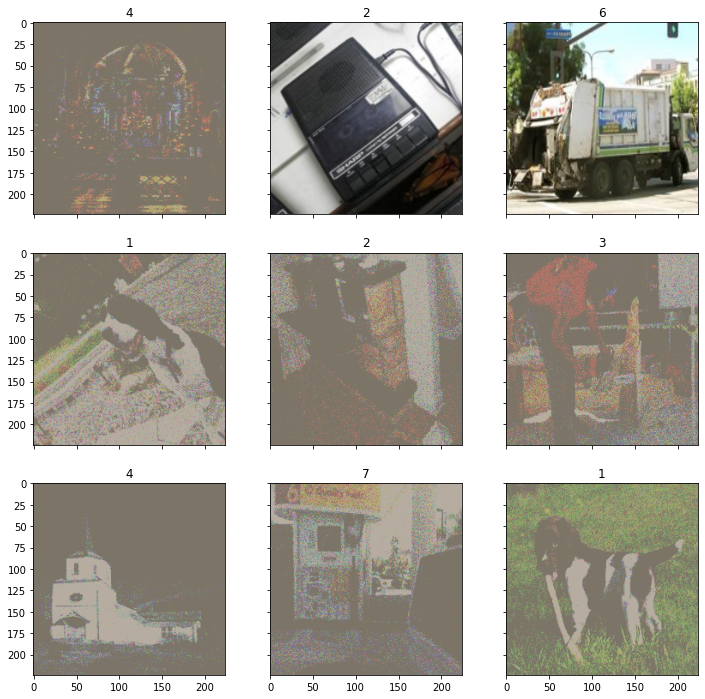

In [39]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), 
                       sharey=True, sharex=True)
                       
for fig_x in ax.flatten():
    random_img = int(np.random.uniform(0,len(train_files)))
    im_val, label = train_dataset[random_img]
    img_label = label
    imshow(im_val.data.cpu(), title=img_label,plt_ax=fig_x)

In [40]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.batch_size,
                                           shuffle=True, num_workers=CFG.num_workers)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=CFG.batch_size,
                                           shuffle=False, num_workers=CFG.num_workers)

print('Train and Valid datasets are loaded:\n')
print('{:<7s}{:>10s}{:>10s}'.format('Dataset', 'Batches', 'Pictures')), print('-' * 28)
print('{:<7s}{:>10d}{:>10d}'.format('Train', len(train_loader), len(train_dataset)))
print('{:<7s}{:>10d}{:>10d}'.format('Valid', len(valid_loader), len(val_dataset)))

Train and Valid datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train        1184      9469
Valid         491      3925


In [19]:
# Функция обучения и инференса модели

def train_val_model(model, loss, optimizer, scheduler, num_epochs):
 
    loss_hist = {'train':[], 'val':[]}
    acc_hist = {'train':[], 'val':[]}
    
    best_acc = 0.

    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, name=CFG.model_name, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    seed_everything(CFG.seed)

    for epoch in range(num_epochs):
        print("Epoch {}/{}:".format(epoch+1, num_epochs), end="\n")
        for phase in ['train', 'val']:
            if phase == 'train': # Если фаза == train 
                dataloader = train_loader # Берем train_dataset
                scheduler.step() # Делаем 1 шаг (произошла одна эпоха)
                model.train() # Модель в training mode - обучение (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
            else: # Если фаза == val
                dataloader = valid_loader # Берем valid_dataset 
                model.eval() # Модель в evaluate mode - валидация (Фиксируем модель, иначе у нас могут изменяться параметры слоя батч-нормализации и изменится нейронка с течением времени)
 
            running_loss = 0. 
            running_acc = 0.
 
            # Итерируемся по dataloader
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device) # Тензор с изображениями переводим на GPU 
                labels = labels.to(device) # Тензор с лейблами переводим на GPU 
 
                optimizer.zero_grad() # Обнуляем градиент,чтобы он не накапливался 
 
                with torch.set_grad_enabled(phase == 'train'): # Если фаза train, то активируем все градиенты (те, которые не заморожены)
                    preds = model(inputs) # Считаем предикты, input передаем в модель
                    loss_value = loss(preds, labels) # Посчитали  Loss    
                    preds_class = preds.argmax(dim=1) # Получаем класс, берем .argmax(dim=1) нейрон с максимальной активацией
                
                    if phase == 'train':
                        loss_value.backward() # Считаем градиент 
                        optimizer.step() # Считаем шаг градиентного спуска
 
                # Статистика
                running_loss += loss_value.item() # Считаем Loss
                running_acc += (preds_class == labels.data).float().mean().data.cpu().numpy()  # Считаем accuracy
 
            epoch_loss = running_loss / len(dataloader)  # Loss'ы делим на кол-во бачей в эпохе 
            epoch_acc = running_acc / len(dataloader) # Считаем Loss на кол-во бачей в эпохе
            
            if CFG.wandb and phase == 'train':
              wandb.log({'train_loss': epoch_loss,
                   'train_accuracy': epoch_acc})

            if CFG.wandb and phase == 'val':
              wandb.log({'test_loss': epoch_loss,
                   'test_accuracy': epoch_acc})
               
            print("{} loss: {:.2f} accuracy: {:.2f}".format(phase, epoch_loss, epoch_acc), end="\n")

            if phase == 'val' and epoch_acc > best_acc:
              best_acc = epoch_acc
              print(f'Epoch {epoch+1} - Save Best Accuracy: {best_acc:.2f} Model\n')
              torch.save(model.state_dict(), '/content/'+f'{CFG.model_name}_best.pth')
            
            loss_hist[phase].append(epoch_loss)
            acc_hist[phase].append(epoch_acc)
        
    return model, loss_hist, acc_hist

## Подзадача №2. 
Изучить внимательно, какие модели есть в библиотеке `timm` и выбрать несколько.

In [68]:
# ====================================================
# My_Net - класс для создания модели
# ====================================================

class My_Net(torch.nn.Module):
    def __init__(self, model_name='resnet50', pretrained=False, effnet=False, value=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        
        # Замораживаем веса, чтобы не использовать лишние веса в обучении, а обучать только последний слой
        for param in self.model.parameters(): # Проходим по параметрам модели (каждый параметр - это каждый слой, model.parameters нам отдаст некоторый итератор по слоям)
          param.requires_grad = value # Для каждого параметра и слоя:"requires grad = False", то есть уже не требуется вычисление градиента для данного слоя. И получается, что у нас вся сетка будет заморожена, то есть мы не сможем вообще ничего обучать            
        
        # Добавляем полносвязанную классифицирующую голову
        if effnet: # Для EfficientNet есть небольшие отличия в названии слоев
          fc_inputs = self.model.classifier.in_features
          self.model.classifier = nn.Linear(fc_inputs, 10)
        else:
          fc_inputs = self.model.fc.in_features
          self.model.fc = nn.Linear(fc_inputs, 10)

    def forward(self, x):
        x = self.model(x)
        return x

In [41]:
model = My_Net(CFG.model_name, pretrained=True, effnet=False, value=False) # Формат pretrained=True - нам нужны веса, которые получились вследствие обучения этой модели на датасете ImageNet
          
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
 
# Определяем Loss функцию
# В данном случае - это кросс-энтропия
loss = nn.CrossEntropyLoss()

# Метод градиентного спуска AdamW
optimizer = optim.AdamW(params=model.parameters(), lr=CFG.lr)

# Определяем разные типы изменения скорости обучения
def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
          scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='StepLR':
          scheduler = StepLR(optimizer, step_size=CFG.step_size, gamma=CFG.gamma)
        elif CFG.scheduler=='CosineAnnealingLR':
          scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
          scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

scheduler = get_scheduler(optimizer)

Итак, поехали!

In [42]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs=CFG.epochs)

/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1/30:


100%|██████████| 1184/1184 [01:15<00:00, 15.63it/s]


train loss: 1.51 accuracy: 0.63


100%|██████████| 491/491 [00:19<00:00, 25.52it/s]


val loss: 0.60 accuracy: 0.92
Epoch 1 - Save Best Accuracy: 0.92 Model

Epoch 2/30:


100%|██████████| 1184/1184 [01:11<00:00, 16.49it/s]


train loss: 0.97 accuracy: 0.74


100%|██████████| 491/491 [00:21<00:00, 22.71it/s]


val loss: 0.37 accuracy: 0.93
Epoch 2 - Save Best Accuracy: 0.93 Model

Epoch 3/30:


100%|██████████| 1184/1184 [01:11<00:00, 16.61it/s]


train loss: 0.83 accuracy: 0.76


100%|██████████| 491/491 [00:19<00:00, 25.57it/s]


val loss: 0.32 accuracy: 0.93
Epoch 4/30:


100%|██████████| 1184/1184 [01:12<00:00, 16.31it/s]


train loss: 0.78 accuracy: 0.77


100%|██████████| 491/491 [00:18<00:00, 26.45it/s]


val loss: 0.27 accuracy: 0.94
Epoch 4 - Save Best Accuracy: 0.94 Model

Epoch 5/30:


100%|██████████| 1184/1184 [01:13<00:00, 16.17it/s]


train loss: 0.74 accuracy: 0.78


100%|██████████| 491/491 [00:19<00:00, 24.57it/s]


val loss: 0.24 accuracy: 0.94
Epoch 5 - Save Best Accuracy: 0.94 Model

Epoch 6/30:


100%|██████████| 1184/1184 [01:11<00:00, 16.67it/s]


train loss: 0.71 accuracy: 0.78


100%|██████████| 491/491 [00:18<00:00, 26.58it/s]


val loss: 0.24 accuracy: 0.94
Epoch 6 - Save Best Accuracy: 0.94 Model

Epoch 7/30:


100%|██████████| 1184/1184 [01:11<00:00, 16.53it/s]


train loss: 0.69 accuracy: 0.79


100%|██████████| 491/491 [00:19<00:00, 25.33it/s]


val loss: 0.23 accuracy: 0.94
Epoch 8/30:


100%|██████████| 1184/1184 [01:13<00:00, 16.11it/s]


train loss: 0.68 accuracy: 0.79


100%|██████████| 491/491 [00:19<00:00, 24.71it/s]


val loss: 0.24 accuracy: 0.93
Epoch 9/30:


100%|██████████| 1184/1184 [01:10<00:00, 16.73it/s]


train loss: 0.68 accuracy: 0.79


100%|██████████| 491/491 [00:18<00:00, 26.43it/s]


val loss: 0.22 accuracy: 0.94
Epoch 9 - Save Best Accuracy: 0.94 Model

Epoch 10/30:


100%|██████████| 1184/1184 [01:10<00:00, 16.69it/s]


train loss: 0.67 accuracy: 0.79


100%|██████████| 491/491 [00:20<00:00, 24.39it/s]


val loss: 0.22 accuracy: 0.94
Epoch 10 - Save Best Accuracy: 0.94 Model

Epoch 11/30:


100%|██████████| 1184/1184 [01:12<00:00, 16.26it/s]


train loss: 0.64 accuracy: 0.79


100%|██████████| 491/491 [00:18<00:00, 26.29it/s]


val loss: 0.21 accuracy: 0.95
Epoch 11 - Save Best Accuracy: 0.95 Model

Epoch 12/30:


100%|██████████| 1184/1184 [01:12<00:00, 16.27it/s]


train loss: 0.65 accuracy: 0.79


100%|██████████| 491/491 [00:18<00:00, 26.29it/s]


val loss: 0.21 accuracy: 0.94
Epoch 13/30:


100%|██████████| 1184/1184 [01:13<00:00, 16.16it/s]


train loss: 0.63 accuracy: 0.80


100%|██████████| 491/491 [00:20<00:00, 24.47it/s]


val loss: 0.22 accuracy: 0.94
Epoch 14/30:


100%|██████████| 1184/1184 [01:14<00:00, 15.96it/s]


train loss: 0.64 accuracy: 0.80


100%|██████████| 491/491 [00:19<00:00, 25.54it/s]


val loss: 0.22 accuracy: 0.94
Epoch 15/30:


100%|██████████| 1184/1184 [01:14<00:00, 15.98it/s]


train loss: 0.62 accuracy: 0.80


100%|██████████| 491/491 [00:18<00:00, 26.06it/s]


val loss: 0.23 accuracy: 0.94
Epoch 16/30:


100%|██████████| 1184/1184 [01:15<00:00, 15.75it/s]


train loss: 0.65 accuracy: 0.80


100%|██████████| 491/491 [00:18<00:00, 25.86it/s]


val loss: 0.22 accuracy: 0.94
Epoch 17/30:


100%|██████████| 1184/1184 [01:12<00:00, 16.28it/s]


train loss: 0.62 accuracy: 0.80


100%|██████████| 491/491 [00:20<00:00, 24.09it/s]


val loss: 0.22 accuracy: 0.94
Epoch 18/30:


100%|██████████| 1184/1184 [01:13<00:00, 16.14it/s]


train loss: 0.62 accuracy: 0.80


100%|██████████| 491/491 [00:18<00:00, 26.24it/s]


val loss: 0.22 accuracy: 0.94
Epoch 19/30:


100%|██████████| 1184/1184 [01:14<00:00, 15.79it/s]


train loss: 0.63 accuracy: 0.80


100%|██████████| 491/491 [00:18<00:00, 26.41it/s]


val loss: 0.21 accuracy: 0.95
Epoch 20/30:


100%|██████████| 1184/1184 [01:12<00:00, 16.33it/s]


train loss: 0.60 accuracy: 0.81


100%|██████████| 491/491 [00:20<00:00, 23.93it/s]


val loss: 0.21 accuracy: 0.94
Epoch 21/30:


100%|██████████| 1184/1184 [01:13<00:00, 16.11it/s]


train loss: 0.60 accuracy: 0.81


100%|██████████| 491/491 [00:19<00:00, 25.21it/s]


val loss: 0.23 accuracy: 0.93
Epoch 22/30:


100%|██████████| 1184/1184 [01:12<00:00, 16.25it/s]


train loss: 0.60 accuracy: 0.81


100%|██████████| 491/491 [00:18<00:00, 26.30it/s]


val loss: 0.22 accuracy: 0.94
Epoch 23/30:


100%|██████████| 1184/1184 [01:12<00:00, 16.34it/s]


train loss: 0.60 accuracy: 0.81


100%|██████████| 491/491 [00:20<00:00, 24.26it/s]


val loss: 0.22 accuracy: 0.94
Epoch 24/30:


100%|██████████| 1184/1184 [01:13<00:00, 16.09it/s]


train loss: 0.61 accuracy: 0.80


100%|██████████| 491/491 [00:18<00:00, 25.98it/s]


val loss: 0.19 accuracy: 0.95
Epoch 25/30:


100%|██████████| 1184/1184 [01:13<00:00, 16.09it/s]


train loss: 0.61 accuracy: 0.81


100%|██████████| 491/491 [00:18<00:00, 26.09it/s]


val loss: 0.19 accuracy: 0.95
Epoch 26/30:


100%|██████████| 1184/1184 [01:12<00:00, 16.38it/s]


train loss: 0.60 accuracy: 0.81


100%|██████████| 491/491 [00:20<00:00, 24.32it/s]


val loss: 0.21 accuracy: 0.94
Epoch 27/30:


100%|██████████| 1184/1184 [01:13<00:00, 16.05it/s]


train loss: 0.61 accuracy: 0.80


100%|██████████| 491/491 [00:19<00:00, 24.80it/s]


val loss: 0.21 accuracy: 0.94
Epoch 28/30:


100%|██████████| 1184/1184 [01:12<00:00, 16.26it/s]


train loss: 0.60 accuracy: 0.81


100%|██████████| 491/491 [00:18<00:00, 26.26it/s]


val loss: 0.19 accuracy: 0.95
Epoch 29/30:


100%|██████████| 1184/1184 [01:12<00:00, 16.30it/s]


train loss: 0.61 accuracy: 0.81


100%|██████████| 491/491 [00:21<00:00, 23.00it/s]


val loss: 0.21 accuracy: 0.94
Epoch 30/30:


100%|██████████| 1184/1184 [01:11<00:00, 16.54it/s]


train loss: 0.60 accuracy: 0.81


100%|██████████| 491/491 [00:18<00:00, 26.18it/s]

val loss: 0.22 accuracy: 0.94


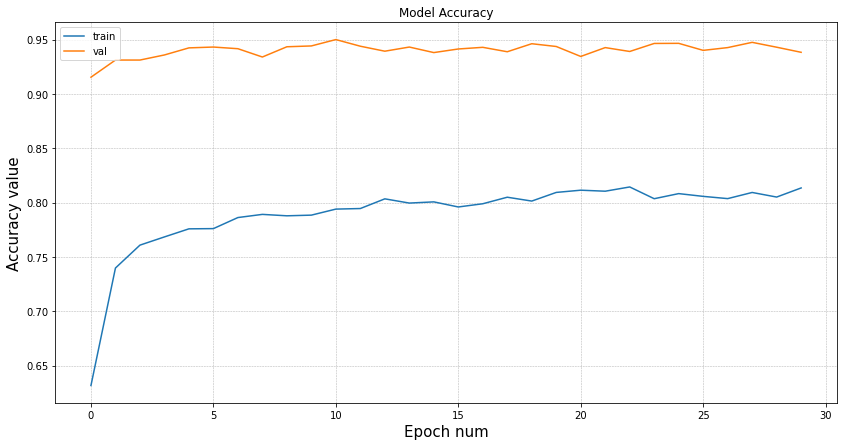

In [43]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

Модель Inception с алгоритмом изменения скорости обучения StepLR достигла максимума Accuracy в 95%. Впервые это произошло на 11 эпохе, а далее было то 94%, то снова 95%. 

Далее, мы будем проводить опыты с другими моделями и разными алгоритмами изменения скорости обучения, но сначала, исходя из итогов озвученных выше, мы уменьшим кол-во эпох до 15, для экономии мощностей предоставляемых Colab-ом, и увеличим размер батчей, для ускорения обучения.



In [64]:
CFG.batch_size = 16
CFG.epochs = 15

In [69]:
# Пересоздаём даталоадеры с новым размером батчей
del train_loader, valid_loader

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG.batch_size,
                                           shuffle=True, num_workers=CFG.num_workers)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=CFG.batch_size,
                                           shuffle=False, num_workers=CFG.num_workers)

print('Train and Valid datasets are loaded:\n')
print('{:<7s}{:>10s}{:>10s}'.format('Dataset', 'Batches', 'Pictures')), print('-' * 28)
print('{:<7s}{:>10d}{:>10d}'.format('Train', len(train_loader), len(train_dataset)))
print('{:<7s}{:>10d}{:>10d}'.format('Valid', len(valid_loader), len(val_dataset)))

Train and Valid datasets are loaded:

Dataset   Batches  Pictures
----------------------------
Train         592      9469
Valid         246      3925


Пробуем другие алгоритмы ускорения обучения с той же моделью - inception.

In [92]:
# Пробуем 'CosineAnnealingLR'

CFG.scheduler = 'CosineAnnealingLR' 

In [93]:
# Удаляем и переинициализируем нашу модель, функцию ошибки, оптимизатор и ускоритель обучения, 

del model, loss, optimizer, scheduler

model = My_Net(CFG.model_name, pretrained=True, effnet=False, value=False)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.AdamW(params=model.parameters(), lr=CFG.lr)

scheduler = get_scheduler(optimizer)

In [94]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs=CFG.epochs)

Epoch 1/15:


100%|██████████| 592/592 [00:59<00:00,  9.93it/s]


train loss: 1.56 accuracy: 0.66


100%|██████████| 246/246 [00:13<00:00, 18.49it/s]


val loss: 0.69 accuracy: 0.92
Epoch 1 - Save Best Accuracy: 0.92 Model

Epoch 2/15:


100%|██████████| 592/592 [01:00<00:00,  9.76it/s]


train loss: 1.00 accuracy: 0.78


100%|██████████| 246/246 [00:13<00:00, 18.31it/s]


val loss: 0.45 accuracy: 0.94
Epoch 2 - Save Best Accuracy: 0.94 Model

Epoch 3/15:


100%|██████████| 592/592 [01:02<00:00,  9.46it/s]


train loss: 0.85 accuracy: 0.79


100%|██████████| 246/246 [00:13<00:00, 18.32it/s]


val loss: 0.38 accuracy: 0.93
Epoch 4/15:


100%|██████████| 592/592 [01:00<00:00,  9.83it/s]


train loss: 0.79 accuracy: 0.80


100%|██████████| 246/246 [00:13<00:00, 18.50it/s]


val loss: 0.35 accuracy: 0.94
Epoch 5/15:


100%|██████████| 592/592 [00:58<00:00, 10.07it/s]


train loss: 0.77 accuracy: 0.80


100%|██████████| 246/246 [00:13<00:00, 18.36it/s]


val loss: 0.33 accuracy: 0.94
Epoch 5 - Save Best Accuracy: 0.94 Model

Epoch 6/15:


100%|██████████| 592/592 [01:01<00:00,  9.67it/s]


train loss: 0.76 accuracy: 0.80


100%|██████████| 246/246 [00:13<00:00, 18.55it/s]


val loss: 0.34 accuracy: 0.94
Epoch 7/15:


100%|██████████| 592/592 [00:58<00:00, 10.20it/s]


train loss: 0.76 accuracy: 0.80


100%|██████████| 246/246 [00:13<00:00, 18.39it/s]


val loss: 0.32 accuracy: 0.94
Epoch 8/15:


100%|██████████| 592/592 [00:58<00:00, 10.13it/s]


train loss: 0.74 accuracy: 0.80


100%|██████████| 246/246 [00:13<00:00, 18.44it/s]


val loss: 0.32 accuracy: 0.94
Epoch 9/15:


100%|██████████| 592/592 [00:59<00:00,  9.92it/s]


train loss: 0.73 accuracy: 0.80


100%|██████████| 246/246 [00:13<00:00, 18.55it/s]


val loss: 0.29 accuracy: 0.94
Epoch 10/15:


100%|██████████| 592/592 [01:00<00:00,  9.76it/s]


train loss: 0.69 accuracy: 0.80


100%|██████████| 246/246 [00:12<00:00, 19.00it/s]


val loss: 0.27 accuracy: 0.94
Epoch 10 - Save Best Accuracy: 0.94 Model

Epoch 11/15:


100%|██████████| 592/592 [00:59<00:00,  9.91it/s]


train loss: 0.65 accuracy: 0.81


100%|██████████| 246/246 [00:13<00:00, 18.62it/s]


val loss: 0.24 accuracy: 0.95
Epoch 11 - Save Best Accuracy: 0.95 Model

Epoch 12/15:


100%|██████████| 592/592 [00:58<00:00, 10.17it/s]


train loss: 0.63 accuracy: 0.81


100%|██████████| 246/246 [00:13<00:00, 18.60it/s]


val loss: 0.23 accuracy: 0.94
Epoch 13/15:


100%|██████████| 592/592 [00:59<00:00,  9.87it/s]


train loss: 0.59 accuracy: 0.82


100%|██████████| 246/246 [00:13<00:00, 18.47it/s]


val loss: 0.22 accuracy: 0.95
Epoch 13 - Save Best Accuracy: 0.95 Model

Epoch 14/15:


100%|██████████| 592/592 [00:58<00:00, 10.11it/s]


train loss: 0.59 accuracy: 0.82


100%|██████████| 246/246 [00:13<00:00, 18.52it/s]


val loss: 0.22 accuracy: 0.95
Epoch 14 - Save Best Accuracy: 0.95 Model

Epoch 15/15:


100%|██████████| 592/592 [00:58<00:00, 10.07it/s]


train loss: 0.59 accuracy: 0.82


100%|██████████| 246/246 [00:13<00:00, 18.44it/s]

val loss: 0.22 accuracy: 0.95


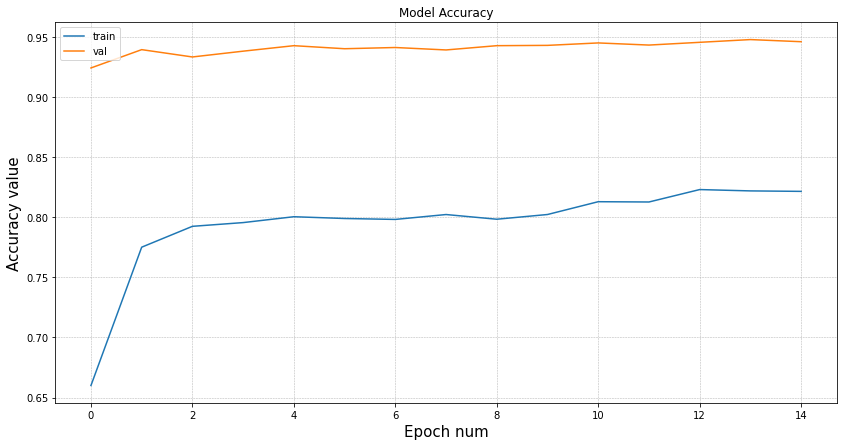

In [95]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

Можно заметить, что по сравнению со StepLR, CosineAnnealingLR быстрее сходится. Например, при StepLR в первой эпохе Accuracy было равно 92, на второй - 93, а на третьей - 94, тогда как CosineAnnealingLR достигла Accuracy в 94 процента уже на 2 эпохе. Также быстрей сходилось и на тренировке. Однако оба алгоритма достигли максимального значения Accuracy в 95% на 11 эпохе. График получился более гладкий чем при StepLR, что может нам говорить о большей "уверености" алгоритма относительно нахождения локального минимума функции ошибки, т.е. у локального минимума лучше сводит скорость обучения к нулю, не давая градиенту "перепрыгнуть" выше.

Теперь перейдём к другому, схожему алгоритму ускорения обучения - CosineAnnealingWarmRestarts

In [96]:
# Пробуем 'CosineAnnealingWarmRestarts'

CFG.scheduler = 'CosineAnnealingWarmRestarts' 

In [97]:
# Удаляем и переинициализируем нашу модель, функцию ошибки, оптимизатор и ускоритель обучения, 

del model, loss, optimizer, scheduler

model = My_Net(CFG.model_name, pretrained=True, effnet=False, value=False)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.AdamW(params=model.parameters(), lr=CFG.lr)

scheduler = get_scheduler(optimizer)

In [98]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs=CFG.epochs)

Epoch 1/15:


100%|██████████| 592/592 [01:01<00:00,  9.68it/s]


train loss: 1.59 accuracy: 0.64


100%|██████████| 246/246 [00:14<00:00, 17.06it/s]


val loss: 0.71 accuracy: 0.92
Epoch 1 - Save Best Accuracy: 0.92 Model

Epoch 2/15:


100%|██████████| 592/592 [00:59<00:00, 10.01it/s]


train loss: 1.01 accuracy: 0.77


100%|██████████| 246/246 [00:13<00:00, 17.84it/s]


val loss: 0.45 accuracy: 0.94
Epoch 2 - Save Best Accuracy: 0.94 Model

Epoch 3/15:


100%|██████████| 592/592 [00:58<00:00, 10.15it/s]


train loss: 0.85 accuracy: 0.79


100%|██████████| 246/246 [00:13<00:00, 18.21it/s]


val loss: 0.39 accuracy: 0.93
Epoch 4/15:


100%|██████████| 592/592 [00:58<00:00, 10.09it/s]


train loss: 0.79 accuracy: 0.80


100%|██████████| 246/246 [00:13<00:00, 18.62it/s]


val loss: 0.35 accuracy: 0.94
Epoch 4 - Save Best Accuracy: 0.94 Model

Epoch 5/15:


100%|██████████| 592/592 [00:58<00:00, 10.11it/s]


train loss: 0.77 accuracy: 0.80


100%|██████████| 246/246 [00:13<00:00, 18.56it/s]


val loss: 0.33 accuracy: 0.94
Epoch 5 - Save Best Accuracy: 0.94 Model

Epoch 6/15:


100%|██████████| 592/592 [01:04<00:00,  9.14it/s]


train loss: 0.73 accuracy: 0.80


100%|██████████| 246/246 [00:18<00:00, 12.96it/s]


val loss: 0.28 accuracy: 0.95
Epoch 6 - Save Best Accuracy: 0.95 Model

Epoch 7/15:


100%|██████████| 592/592 [00:59<00:00, 10.03it/s]


train loss: 0.68 accuracy: 0.80


100%|██████████| 246/246 [00:13<00:00, 18.26it/s]


val loss: 0.25 accuracy: 0.94
Epoch 8/15:


100%|██████████| 592/592 [00:59<00:00,  9.99it/s]


train loss: 0.63 accuracy: 0.82


100%|██████████| 246/246 [00:13<00:00, 18.43it/s]


val loss: 0.25 accuracy: 0.94
Epoch 9/15:


100%|██████████| 592/592 [00:58<00:00, 10.04it/s]


train loss: 0.64 accuracy: 0.81


100%|██████████| 246/246 [00:14<00:00, 17.10it/s]


val loss: 0.23 accuracy: 0.94
Epoch 10/15:


100%|██████████| 592/592 [00:58<00:00, 10.07it/s]


train loss: 0.62 accuracy: 0.81


100%|██████████| 246/246 [00:13<00:00, 18.27it/s]


val loss: 0.24 accuracy: 0.95
Epoch 11/15:


100%|██████████| 592/592 [01:03<00:00,  9.34it/s]


train loss: 0.60 accuracy: 0.82


100%|██████████| 246/246 [00:13<00:00, 18.32it/s]


val loss: 0.23 accuracy: 0.94
Epoch 12/15:


100%|██████████| 592/592 [00:58<00:00, 10.08it/s]


train loss: 0.61 accuracy: 0.82


100%|██████████| 246/246 [00:13<00:00, 18.37it/s]


val loss: 0.22 accuracy: 0.94
Epoch 13/15:


100%|██████████| 592/592 [00:58<00:00, 10.08it/s]


train loss: 0.58 accuracy: 0.83


100%|██████████| 246/246 [00:13<00:00, 18.41it/s]


val loss: 0.22 accuracy: 0.94
Epoch 14/15:


100%|██████████| 592/592 [00:58<00:00, 10.07it/s]


train loss: 0.57 accuracy: 0.83


100%|██████████| 246/246 [00:14<00:00, 16.85it/s]


val loss: 0.21 accuracy: 0.95
Epoch 14 - Save Best Accuracy: 0.95 Model

Epoch 15/15:


100%|██████████| 592/592 [01:01<00:00,  9.63it/s]


train loss: 0.57 accuracy: 0.82


100%|██████████| 246/246 [00:13<00:00, 18.06it/s]

val loss: 0.22 accuracy: 0.95


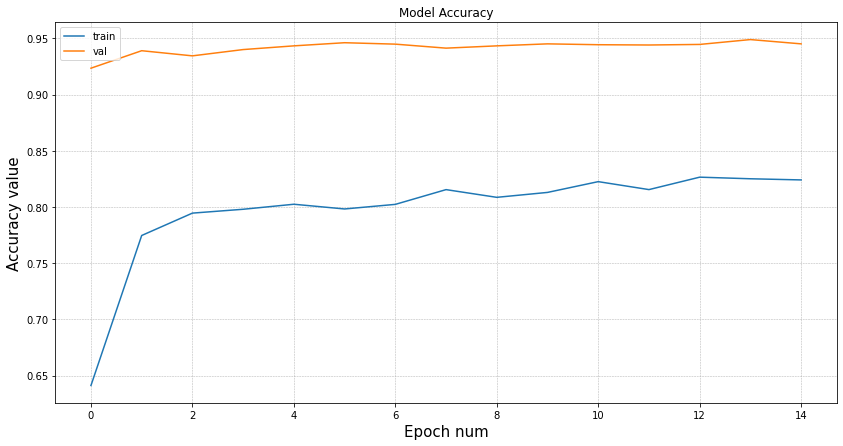

In [99]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

Алгоритм сработал почти также как и предыдущий, но за тем исключением, что с ним модель достигла Accuracy в 95% на 6-ой эпохе, а не на 11.

Остался последний алгоритм - ReduceLROnPlateau

In [100]:
# Пробуем 'ReduceLROnPlateau'

CFG.scheduler = 'ReduceLROnPlateau' 

In [101]:
# Удаляем и переинициализируем нашу модель, функцию ошибки, оптимизатор и ускоритель обучения, 

del model, loss, optimizer, scheduler

model = My_Net(CFG.model_name, pretrained=True, effnet=False, value=False)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.AdamW(params=model.parameters(), lr=CFG.lr)

scheduler = get_scheduler(optimizer)

In [102]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs=CFG.epochs)

Epoch 1/15:


TypeError: ignored

Данный алгоритм не работает, так как при нём нужно передавать в step аргумент metrics. Оставим всё как есть, чтобы не терять время.

Дальше будем пробовать уже другие модели и будем это делать с алгоритмом CosineAnnealingWarmRestarts, так как он чуть лучше сработал чем другие.

In [103]:
# Возвращаем 'CosineAnnealingWarmRestarts'

CFG.scheduler = 'CosineAnnealingWarmRestarts' 

Начнем с Resnet50. Для этого не потребуется что-то менять в CFG, так как Resnet50 стоит по умолчанию в модели, нам достаточно лишь не указывать имя модели в атрибутах.

In [104]:
# Удаляем и переинициализируем нашу модель, функцию ошибки, оптимизатор и ускоритель обучения, 

del model, loss, optimizer, scheduler

model = My_Net(pretrained=True, effnet=False, value=False)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.AdamW(params=model.parameters(), lr=CFG.lr)

scheduler = get_scheduler(optimizer)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


In [105]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs=CFG.epochs)

Epoch 1/15:


100%|██████████| 592/592 [00:54<00:00, 10.78it/s]


train loss: 1.99 accuracy: 0.63


100%|██████████| 246/246 [00:14<00:00, 16.40it/s]


val loss: 1.66 accuracy: 0.90
Epoch 1 - Save Best Accuracy: 0.90 Model

Epoch 2/15:


100%|██████████| 592/592 [00:55<00:00, 10.69it/s]


train loss: 1.54 accuracy: 0.78


100%|██████████| 246/246 [00:14<00:00, 16.53it/s]


val loss: 1.20 accuracy: 0.95
Epoch 2 - Save Best Accuracy: 0.95 Model

Epoch 3/15:


100%|██████████| 592/592 [00:54<00:00, 10.79it/s]


train loss: 1.31 accuracy: 0.79


100%|██████████| 246/246 [00:15<00:00, 16.25it/s]


val loss: 1.07 accuracy: 0.95
Epoch 4/15:


100%|██████████| 592/592 [00:54<00:00, 10.83it/s]


train loss: 1.20 accuracy: 0.80


100%|██████████| 246/246 [00:15<00:00, 16.17it/s]


val loss: 0.98 accuracy: 0.95
Epoch 4 - Save Best Accuracy: 0.95 Model

Epoch 5/15:


100%|██████████| 592/592 [00:54<00:00, 10.93it/s]


train loss: 1.16 accuracy: 0.80


100%|██████████| 246/246 [00:15<00:00, 16.15it/s]


val loss: 1.00 accuracy: 0.95
Epoch 6/15:


100%|██████████| 592/592 [00:54<00:00, 10.91it/s]


train loss: 1.04 accuracy: 0.81


100%|██████████| 246/246 [00:15<00:00, 16.05it/s]


val loss: 0.67 accuracy: 0.96
Epoch 6 - Save Best Accuracy: 0.96 Model

Epoch 7/15:


100%|██████████| 592/592 [00:54<00:00, 10.91it/s]


train loss: 0.89 accuracy: 0.82


100%|██████████| 246/246 [00:15<00:00, 15.91it/s]


val loss: 0.55 accuracy: 0.96
Epoch 7 - Save Best Accuracy: 0.96 Model

Epoch 8/15:


100%|██████████| 592/592 [00:55<00:00, 10.75it/s]


train loss: 0.80 accuracy: 0.83


100%|██████████| 246/246 [00:15<00:00, 16.06it/s]


val loss: 0.52 accuracy: 0.95
Epoch 9/15:


100%|██████████| 592/592 [00:55<00:00, 10.70it/s]


train loss: 0.77 accuracy: 0.83


100%|██████████| 246/246 [00:15<00:00, 16.04it/s]


val loss: 0.47 accuracy: 0.97
Epoch 9 - Save Best Accuracy: 0.97 Model

Epoch 10/15:


100%|██████████| 592/592 [00:55<00:00, 10.72it/s]


train loss: 0.75 accuracy: 0.83


100%|██████████| 246/246 [00:15<00:00, 16.10it/s]


val loss: 0.42 accuracy: 0.97
Epoch 10 - Save Best Accuracy: 0.97 Model

Epoch 11/15:


100%|██████████| 592/592 [00:55<00:00, 10.59it/s]


train loss: 0.73 accuracy: 0.84


100%|██████████| 246/246 [00:15<00:00, 16.37it/s]


val loss: 0.49 accuracy: 0.96
Epoch 12/15:


100%|██████████| 592/592 [00:53<00:00, 10.97it/s]


train loss: 0.71 accuracy: 0.83


100%|██████████| 246/246 [00:15<00:00, 16.03it/s]


val loss: 0.34 accuracy: 0.97
Epoch 12 - Save Best Accuracy: 0.97 Model

Epoch 13/15:


100%|██████████| 592/592 [00:53<00:00, 11.00it/s]


train loss: 0.65 accuracy: 0.84


100%|██████████| 246/246 [00:15<00:00, 15.96it/s]


val loss: 0.36 accuracy: 0.96
Epoch 14/15:


100%|██████████| 592/592 [00:54<00:00, 10.94it/s]


train loss: 0.63 accuracy: 0.84


100%|██████████| 246/246 [00:15<00:00, 16.19it/s]


val loss: 0.30 accuracy: 0.97
Epoch 15/15:


100%|██████████| 592/592 [00:54<00:00, 10.79it/s]


train loss: 0.62 accuracy: 0.84


100%|██████████| 246/246 [00:15<00:00, 15.98it/s]

val loss: 0.31 accuracy: 0.96


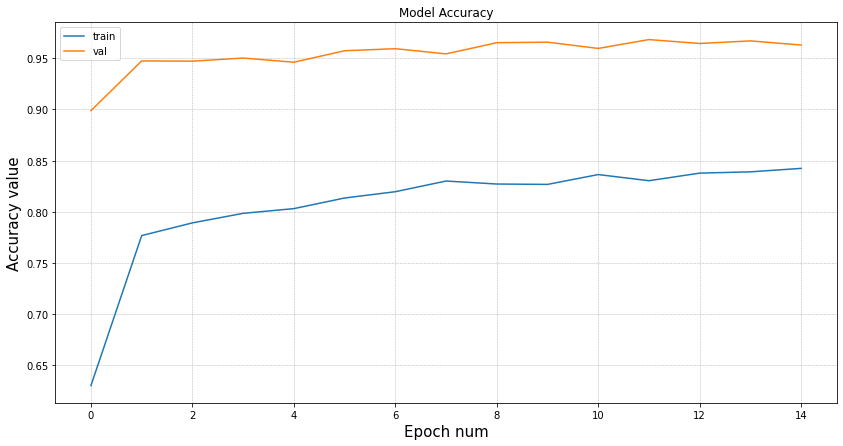

In [106]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

Несмотря на то, что в первой эпохе Accuracy = 90, что на два процента меньше чем в предыдущих опытах, на второй эпохе мы сразу достигли 95% - максимального результата Inception. На 6-ой эпохе удалось побить результат предыдущих испытаний и показать Accuracy в 96%, а на 9-ой эпохе достигнуть 97%. Мы всё ближе к цели нашей работы. 

Теперь испытаем Resnext, улучшеную модель Resnet-а.

In [107]:
# Удаляем и переинициализируем нашу модель, функцию ошибки, оптимизатор и ускоритель обучения, 

del model, loss, optimizer, scheduler

model = My_Net('resnext101_32x8d', pretrained=True, effnet=False, value=False)
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.AdamW(params=model.parameters(), lr=CFG.lr)

scheduler = get_scheduler(optimizer)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [108]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs=CFG.epochs)

Epoch 1/15:


100%|██████████| 592/592 [02:02<00:00,  4.85it/s]


train loss: 1.28 accuracy: 0.73


100%|██████████| 246/246 [00:48<00:00,  5.06it/s]


val loss: 0.30 accuracy: 0.98
Epoch 1 - Save Best Accuracy: 0.98 Model

Epoch 2/15:


100%|██████████| 592/592 [02:02<00:00,  4.84it/s]


train loss: 0.67 accuracy: 0.85


100%|██████████| 246/246 [00:48<00:00,  5.07it/s]


val loss: 0.15 accuracy: 0.98
Epoch 2 - Save Best Accuracy: 0.98 Model

Epoch 3/15:


100%|██████████| 592/592 [02:02<00:00,  4.85it/s]


train loss: 0.55 accuracy: 0.87


100%|██████████| 246/246 [00:48<00:00,  5.08it/s]


val loss: 0.12 accuracy: 0.98
Epoch 3 - Save Best Accuracy: 0.98 Model

Epoch 4/15:


100%|██████████| 592/592 [02:02<00:00,  4.85it/s]


train loss: 0.52 accuracy: 0.87


100%|██████████| 246/246 [00:48<00:00,  5.06it/s]


val loss: 0.11 accuracy: 0.99
Epoch 4 - Save Best Accuracy: 0.99 Model

Epoch 5/15:


100%|██████████| 592/592 [02:02<00:00,  4.84it/s]


train loss: 0.50 accuracy: 0.87


100%|██████████| 246/246 [00:48<00:00,  5.08it/s]


val loss: 0.10 accuracy: 0.99
Epoch 6/15:


100%|██████████| 592/592 [02:02<00:00,  4.85it/s]


train loss: 0.47 accuracy: 0.87


100%|██████████| 246/246 [00:48<00:00,  5.07it/s]


val loss: 0.08 accuracy: 0.99
Epoch 6 - Save Best Accuracy: 0.99 Model

Epoch 7/15:


100%|██████████| 592/592 [02:02<00:00,  4.85it/s]


train loss: 0.43 accuracy: 0.87


100%|██████████| 246/246 [00:48<00:00,  5.09it/s]


val loss: 0.07 accuracy: 0.99
Epoch 8/15:


100%|██████████| 592/592 [02:02<00:00,  4.85it/s]


train loss: 0.40 accuracy: 0.88


100%|██████████| 246/246 [00:48<00:00,  5.06it/s]


val loss: 0.07 accuracy: 0.99
Epoch 9/15:


100%|██████████| 592/592 [02:01<00:00,  4.85it/s]


train loss: 0.40 accuracy: 0.88


100%|██████████| 246/246 [00:48<00:00,  5.05it/s]


val loss: 0.06 accuracy: 0.99
Epoch 9 - Save Best Accuracy: 0.99 Model

Epoch 10/15:


100%|██████████| 592/592 [02:02<00:00,  4.84it/s]


train loss: 0.39 accuracy: 0.88


100%|██████████| 246/246 [00:48<00:00,  5.09it/s]


val loss: 0.06 accuracy: 0.99
Epoch 11/15:


100%|██████████| 592/592 [02:02<00:00,  4.85it/s]


train loss: 0.38 accuracy: 0.89


100%|██████████| 246/246 [00:48<00:00,  5.04it/s]


val loss: 0.06 accuracy: 0.99
Epoch 12/15:


100%|██████████| 592/592 [02:07<00:00,  4.64it/s]


train loss: 0.39 accuracy: 0.88


100%|██████████| 246/246 [00:50<00:00,  4.91it/s]


val loss: 0.06 accuracy: 0.99
Epoch 13/15:


100%|██████████| 592/592 [02:07<00:00,  4.63it/s]


train loss: 0.36 accuracy: 0.89


100%|██████████| 246/246 [00:48<00:00,  5.05it/s]


val loss: 0.05 accuracy: 0.99
Epoch 13 - Save Best Accuracy: 0.99 Model

Epoch 14/15:


100%|██████████| 592/592 [02:02<00:00,  4.84it/s]


train loss: 0.35 accuracy: 0.89


100%|██████████| 246/246 [00:48<00:00,  5.06it/s]


val loss: 0.05 accuracy: 0.99
Epoch 15/15:


100%|██████████| 592/592 [02:02<00:00,  4.84it/s]


train loss: 0.36 accuracy: 0.89


100%|██████████| 246/246 [00:48<00:00,  5.05it/s]

val loss: 0.06 accuracy: 0.99


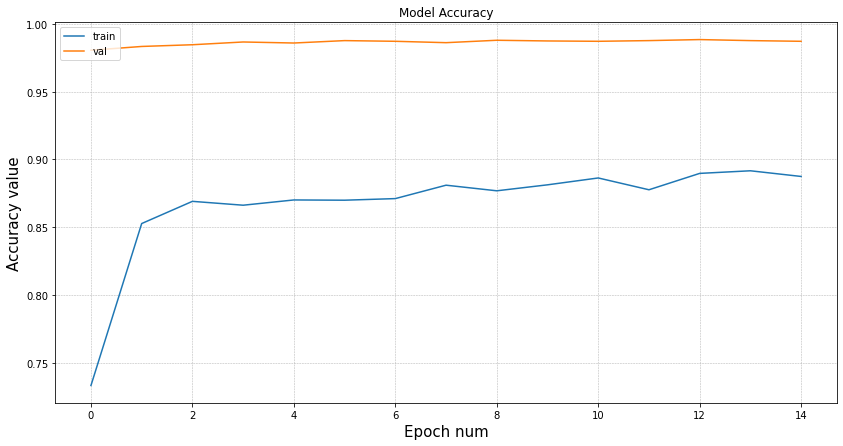

In [109]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

Resnext с первой эпохи достиг цели нашей работы - Accuracy в 98 процентов. А на 4-ой эпохе - 99%. Скорей всего это безоговорочный лидер, но тем не менее, мы продолжим изучать оставшиеся модели: Densenet и Efficientnet.

Продолжим с Densenet

In [117]:
# Удаляем и переинициализируем нашу модель, функцию ошибки, оптимизатор и ускоритель обучения, 

del model, loss, optimizer, scheduler

# параметр effnet выставляем в True, поскольку в Densenet нет метода fc
model = My_Net('densenet169', pretrained=True, effnet=True, value=False) 
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.AdamW(params=model.parameters(), lr=CFG.lr)

scheduler = get_scheduler(optimizer)

In [118]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs=CFG.epochs)

Epoch 1/15:


100%|██████████| 592/592 [01:12<00:00,  8.14it/s]


train loss: 1.58 accuracy: 0.64


100%|██████████| 246/246 [00:21<00:00, 11.68it/s]


val loss: 0.67 accuracy: 0.94
Epoch 1 - Save Best Accuracy: 0.94 Model

Epoch 2/15:


100%|██████████| 592/592 [01:11<00:00,  8.27it/s]


train loss: 0.89 accuracy: 0.83


100%|██████████| 246/246 [00:21<00:00, 11.54it/s]


val loss: 0.35 accuracy: 0.96
Epoch 2 - Save Best Accuracy: 0.96 Model

Epoch 3/15:


100%|██████████| 592/592 [01:10<00:00,  8.36it/s]


train loss: 0.71 accuracy: 0.85


100%|██████████| 246/246 [00:20<00:00, 12.18it/s]


val loss: 0.28 accuracy: 0.96
Epoch 3 - Save Best Accuracy: 0.96 Model

Epoch 4/15:


100%|██████████| 592/592 [01:11<00:00,  8.28it/s]


train loss: 0.65 accuracy: 0.86


100%|██████████| 246/246 [00:21<00:00, 11.50it/s]


val loss: 0.24 accuracy: 0.96
Epoch 4 - Save Best Accuracy: 0.96 Model

Epoch 5/15:


100%|██████████| 592/592 [01:10<00:00,  8.35it/s]


train loss: 0.62 accuracy: 0.86


100%|██████████| 246/246 [00:21<00:00, 11.58it/s]


val loss: 0.23 accuracy: 0.96
Epoch 5 - Save Best Accuracy: 0.96 Model

Epoch 6/15:


100%|██████████| 592/592 [01:11<00:00,  8.25it/s]


train loss: 0.57 accuracy: 0.86


100%|██████████| 246/246 [00:20<00:00, 12.19it/s]


val loss: 0.18 accuracy: 0.97
Epoch 6 - Save Best Accuracy: 0.97 Model

Epoch 7/15:


100%|██████████| 592/592 [01:11<00:00,  8.26it/s]


train loss: 0.50 accuracy: 0.86


100%|██████████| 246/246 [00:21<00:00, 11.47it/s]


val loss: 0.14 accuracy: 0.97
Epoch 7 - Save Best Accuracy: 0.97 Model

Epoch 8/15:


100%|██████████| 592/592 [01:12<00:00,  8.22it/s]


train loss: 0.47 accuracy: 0.87


100%|██████████| 246/246 [00:21<00:00, 11.55it/s]


val loss: 0.14 accuracy: 0.97
Epoch 9/15:


100%|██████████| 592/592 [01:11<00:00,  8.33it/s]


train loss: 0.46 accuracy: 0.87


100%|██████████| 246/246 [00:20<00:00, 12.13it/s]


val loss: 0.13 accuracy: 0.97
Epoch 10/15:


100%|██████████| 592/592 [01:11<00:00,  8.31it/s]


train loss: 0.45 accuracy: 0.87


100%|██████████| 246/246 [00:21<00:00, 11.60it/s]


val loss: 0.12 accuracy: 0.97
Epoch 10 - Save Best Accuracy: 0.97 Model

Epoch 11/15:


100%|██████████| 592/592 [01:14<00:00,  7.93it/s]


train loss: 0.44 accuracy: 0.88


100%|██████████| 246/246 [00:24<00:00,  9.95it/s]


val loss: 0.13 accuracy: 0.97
Epoch 12/15:


100%|██████████| 592/592 [01:18<00:00,  7.53it/s]


train loss: 0.43 accuracy: 0.88


100%|██████████| 246/246 [00:28<00:00,  8.78it/s]


val loss: 0.11 accuracy: 0.97
Epoch 12 - Save Best Accuracy: 0.97 Model

Epoch 13/15:


100%|██████████| 592/592 [01:18<00:00,  7.49it/s]


train loss: 0.40 accuracy: 0.88


100%|██████████| 246/246 [00:21<00:00, 11.68it/s]


val loss: 0.11 accuracy: 0.97
Epoch 13 - Save Best Accuracy: 0.97 Model

Epoch 14/15:


100%|██████████| 592/592 [01:16<00:00,  7.70it/s]


train loss: 0.40 accuracy: 0.88


100%|██████████| 246/246 [00:22<00:00, 11.17it/s]


val loss: 0.11 accuracy: 0.98
Epoch 14 - Save Best Accuracy: 0.98 Model

Epoch 15/15:


100%|██████████| 592/592 [01:24<00:00,  6.98it/s]


train loss: 0.40 accuracy: 0.88


100%|██████████| 246/246 [00:22<00:00, 10.87it/s]

val loss: 0.11 accuracy: 0.97


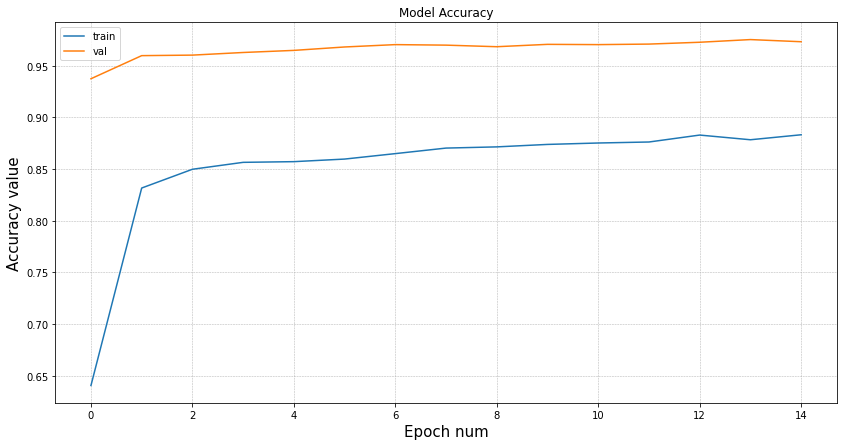

In [119]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

Densenet показал результаты лучше чем Inception и ± также как Resnet, а также на 14-ой эпохе смог достичь Accuracy в 98%, однако не смог побить результаты Resnext.

Осталась последня модель - Efficientnet

In [120]:
# Удаляем и переинициализируем нашу модель, функцию ошибки, оптимизатор и ускоритель обучения, 

del model, loss, optimizer, scheduler

# параметр effnet выставляем в True
model = My_Net('efficientnet_b0', pretrained=True, effnet=True, value=False) 
model = model.to(device)

loss = nn.CrossEntropyLoss()

optimizer = optim.AdamW(params=model.parameters(), lr=CFG.lr)

scheduler = get_scheduler(optimizer)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth


In [121]:
model, loss, acc = train_val_model(model, loss, optimizer, scheduler, num_epochs=CFG.epochs)

Epoch 1/15:


100%|██████████| 592/592 [00:55<00:00, 10.70it/s]


train loss: 1.69 accuracy: 0.64


100%|██████████| 246/246 [00:11<00:00, 21.46it/s]


val loss: 0.99 accuracy: 0.94
Epoch 1 - Save Best Accuracy: 0.94 Model

Epoch 2/15:


100%|██████████| 592/592 [00:54<00:00, 10.87it/s]


train loss: 1.08 accuracy: 0.78


100%|██████████| 246/246 [00:09<00:00, 24.68it/s]


val loss: 0.59 accuracy: 0.96
Epoch 2 - Save Best Accuracy: 0.96 Model

Epoch 3/15:


100%|██████████| 592/592 [00:54<00:00, 10.88it/s]


train loss: 0.89 accuracy: 0.80


100%|██████████| 246/246 [00:11<00:00, 21.21it/s]


val loss: 0.49 accuracy: 0.96
Epoch 3 - Save Best Accuracy: 0.96 Model

Epoch 4/15:


100%|██████████| 592/592 [00:54<00:00, 10.90it/s]


train loss: 0.82 accuracy: 0.81


100%|██████████| 246/246 [00:11<00:00, 21.49it/s]


val loss: 0.44 accuracy: 0.96
Epoch 4 - Save Best Accuracy: 0.96 Model

Epoch 5/15:


100%|██████████| 592/592 [00:53<00:00, 11.09it/s]


train loss: 0.79 accuracy: 0.80


100%|██████████| 246/246 [00:10<00:00, 23.28it/s]


val loss: 0.41 accuracy: 0.96
Epoch 5 - Save Best Accuracy: 0.96 Model

Epoch 6/15:


100%|██████████| 592/592 [00:54<00:00, 10.84it/s]


train loss: 0.73 accuracy: 0.81


100%|██████████| 246/246 [00:11<00:00, 21.36it/s]


val loss: 0.30 accuracy: 0.97
Epoch 6 - Save Best Accuracy: 0.97 Model

Epoch 7/15:


100%|██████████| 592/592 [00:54<00:00, 10.90it/s]


train loss: 0.66 accuracy: 0.82


100%|██████████| 246/246 [00:11<00:00, 21.57it/s]


val loss: 0.25 accuracy: 0.97
Epoch 8/15:


100%|██████████| 592/592 [00:52<00:00, 11.18it/s]


train loss: 0.62 accuracy: 0.82


100%|██████████| 246/246 [00:10<00:00, 22.46it/s]


val loss: 0.23 accuracy: 0.97
Epoch 8 - Save Best Accuracy: 0.97 Model

Epoch 9/15:


100%|██████████| 592/592 [00:54<00:00, 10.89it/s]


train loss: 0.62 accuracy: 0.82


100%|██████████| 246/246 [00:11<00:00, 21.74it/s]


val loss: 0.21 accuracy: 0.97
Epoch 9 - Save Best Accuracy: 0.97 Model

Epoch 10/15:


100%|██████████| 592/592 [00:54<00:00, 10.87it/s]


train loss: 0.59 accuracy: 0.83


100%|██████████| 246/246 [00:10<00:00, 23.24it/s]


val loss: 0.20 accuracy: 0.97
Epoch 11/15:


100%|██████████| 592/592 [00:53<00:00, 11.03it/s]


train loss: 0.59 accuracy: 0.83


100%|██████████| 246/246 [00:11<00:00, 21.66it/s]


val loss: 0.21 accuracy: 0.97
Epoch 12/15:


100%|██████████| 592/592 [00:54<00:00, 10.92it/s]


train loss: 0.59 accuracy: 0.83


100%|██████████| 246/246 [00:11<00:00, 21.49it/s]


val loss: 0.17 accuracy: 0.97
Epoch 12 - Save Best Accuracy: 0.97 Model

Epoch 13/15:


100%|██████████| 592/592 [00:53<00:00, 11.02it/s]


train loss: 0.56 accuracy: 0.84


100%|██████████| 246/246 [00:09<00:00, 25.06it/s]


val loss: 0.18 accuracy: 0.97
Epoch 14/15:


100%|██████████| 592/592 [00:54<00:00, 10.93it/s]


train loss: 0.56 accuracy: 0.83


100%|██████████| 246/246 [00:11<00:00, 21.47it/s]


val loss: 0.17 accuracy: 0.97
Epoch 15/15:


100%|██████████| 592/592 [00:54<00:00, 10.88it/s]


train loss: 0.55 accuracy: 0.83


100%|██████████| 246/246 [00:11<00:00, 21.46it/s]

val loss: 0.17 accuracy: 0.97


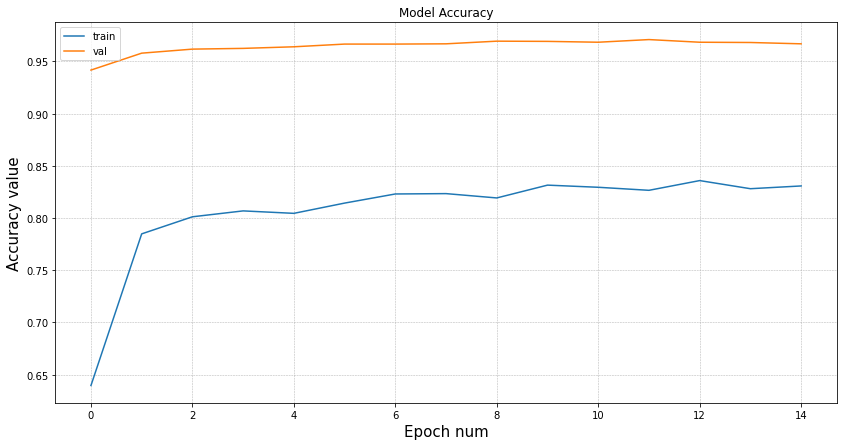

In [122]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc.keys():
    plt.plot(acc[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')

Efficientnet сработал лучше чем Inception и Resnet, однако хуже чем Densenet и не смог достичь нашей цели - Accuracy = 98.

<b>Призовые места (✓ - достиг цели, × - не достиг цели):</b>

>1 место Resnext (Accuracy max - 99) ✓

>2 место Densenet (Accuracy max - 98) ✓

>3 место Efficientnet (Accuracy max - 97) ×

<b>Вывод:</b>

Несмотря на множество проведённых эксперементов, можно было бы проверить ещё влияние изменения размера батчей на общий результат, хотя скорей всего он будет незначительный или отсутсвовать вовсе. Также можно было бы проверить каждый алгоритм ускорения обучения для каждой модели, потому как выбранный нами CosineAnnealingWarmRestarts был лучшим для Inception, но не обязательно лучшим для остальных моделей. Однако проверка всех этих нюансов займёт ещё больше времени и вычислительных мощностей. На проверку всех моделей и алгоритмов ускорения обучения в данной работе ушёл рабочий день.

Также стоит отметить, что получившийся рейтинг моделей не говорит о том, что он будет таким же с другими датасетами. Все полученные результаты характерны лишь для данной работы и могут быть совершено другими в другом исследовании.

Поразителен был результат Resnext. Возможно если пообучать его побольше эпох, то мог бы быть результат в Accuracy равным 100. Если бы такое случилось, то Resnext следовало бы переименовать в Skynet :)